In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as n
import os.path
import datetime

from imp import reload
import copy
import csv

from modules import satellite, thermal, fileio, vis

Populating the interactive namespace from numpy and matplotlib


In [17]:
t_orbit = 92 * 60
dt = 1
path = '/home/ali/UTAT/mission-sim/sources/heron_area.csv'
headers = ['plusX','plusY','negX','negY', 'plusZ', 'negZ']
panels = headers[:4]

areas = fileio.read_areas_from_file(path, dt, t_orbit)
total_areas = areas['plusX'] - areas['plusX']
panel_areas = total_areas.copy()
for h in headers:
    total_areas += areas[h]
    if h in panels: panel_areas += areas[h]
n_pts_per_orbit = len(areas)


In [18]:
timings = {
    'beacon_interval' : 60,
    'beacon_duration' :  3,
    'passover_interval' : 90*60,
    'passover_duration_exp_off' : 600,
    'passover_duration_exp_on' : 60,
    'exp_start_time' : 1  * 60 * 60,
    'exp_duration' : 2 * 24 * 60 * 60
}

temperatures = {'battery': 300,
                'structure': 300,
                'payload':  300}

eps = {'battery_capacity_mAh' : 20000.0,
       'converter_efficiency' : 0.8,
       'starting_charge_frac' : 1.0}

setpoints = {'payload_stasis': 273.15 + 30.0, 'payload_exp': 273.15 + 38.0,'battery': 273.15 + 30.0}

structure_constants = {
    'area_t': 0.0013,  # total surface area of sat
    'r_batt': 130 * 10**-3,  # ohm,s #for self heating
    'R_str_pay': 16.67,  # K/W
    'R_str_batt': 14,  # fake
    'c_str': 900,  # estimate (J/K)
    'c_batt': 850,  # estimate (J/K)
    'c_pay': 800,  # guess (J/K)
    'e': 0.58,  # sat emissivity
    'a': 0.72,  # sat absorbtivity
}

In [19]:
heron = satellite.Satellite(timings,eps, temperatures, setpoints, structure_constants)

heron.get_battery_voltage()

n_orbits = 5
n_points = n_orbits * n_pts_per_orbit
t_sim = n_points * dt

for i in range(n_points):
    heron.set_state(i)
    heron.draw_powers()
    heron.update_thermal(total_areas[i % len(areas)], areas['negZ'][i%len(areas)], heron.batt_current_net)
    heron.charge_from_solar_panel(panel_areas[i % len(areas)] / (0.03 * 0.01), dt)
    heron.update_state_tracker(i*dt)

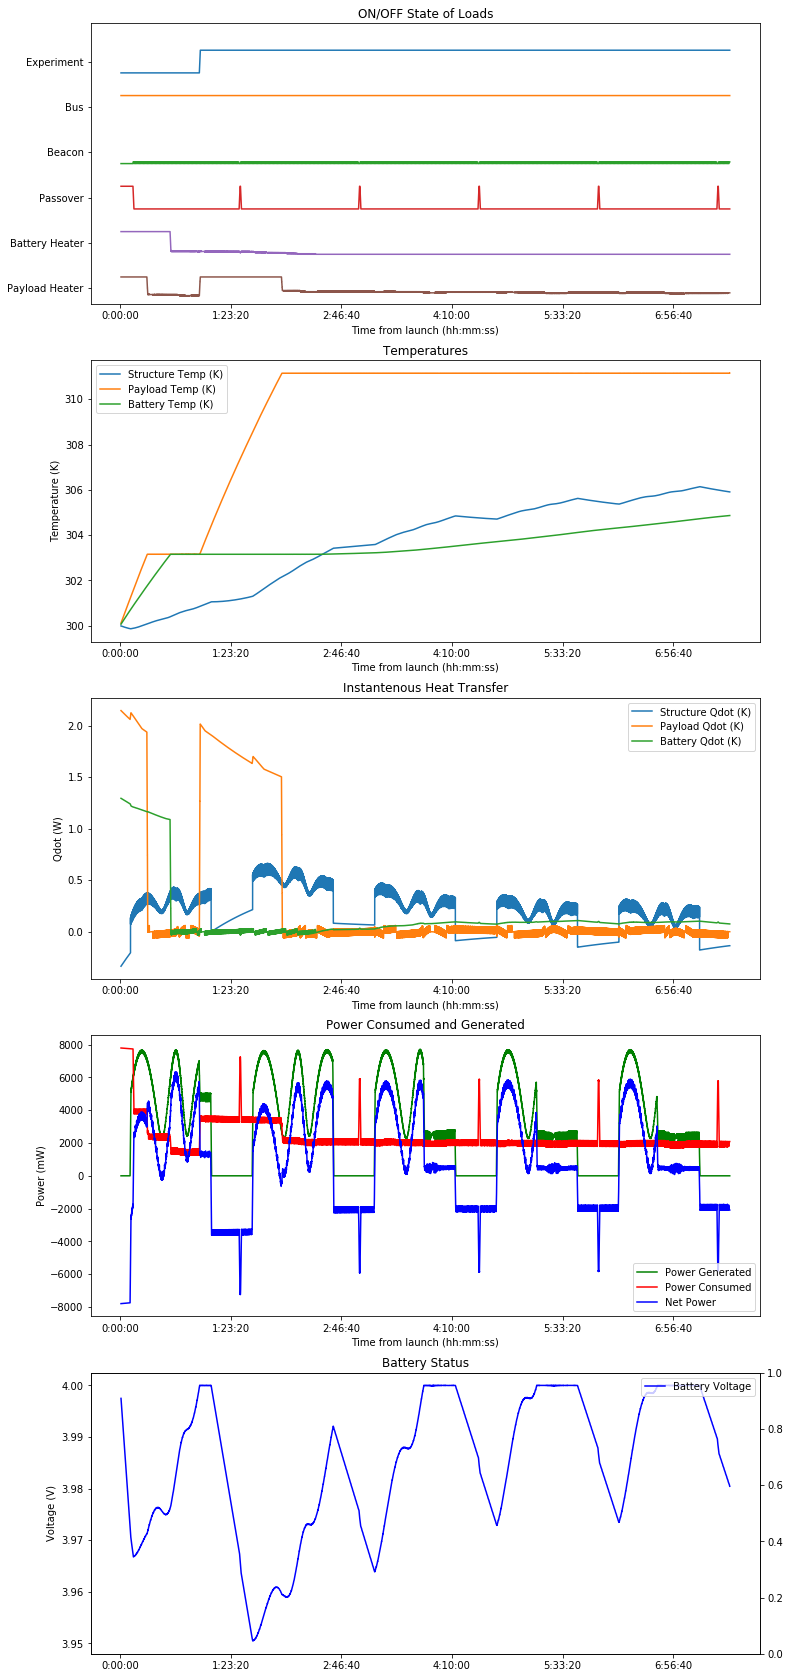

In [20]:
vis.plot_trackers(heron, 40.0);

In [21]:
with open('simulation_currents.csv','w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(['solar_curr_mA', 'load_power_mW'])
    for i in range(len(heron.trackers['batt_current_in'])):
        csvwriter.writerow([heron.trackers['max_solar_current_in_mA'][i], heron.trackers['power_out'][i]])